# Variational inference for Bayesian Gaussian mixture models

In this notebook, variational inference for Bayesian Gaussian mixture models, which is described in Chapter 10 of PRML, is implemented. 

The theory part summarize the result from Section 10.2. Note that derivation is not included in this notebook. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1 Setting

Here we consider a unsupervised learning problem. 

* Let$N \in \mathbb{N}$ be the number of data points, and
* Let $D \in \mathbb{N}$ be the input dimension.
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^D$. 
* Denote the input data collectively by a matrix $X$, where $X_{n,i}$ is $i$-th component of $x_n$.

# 2 Theory

## 2.1 Model

A Gaussian mixture model with $K  \in \mathbb{N}$ components, with prior on parameters, for $N$ data points is defined by 

$$
\begin{align}
    & p(\pi) = {\rm Dir}(\pi | \alpha_0)\\
    & p(Z | \pi) = \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} \pi_{k}^{z_{n,k}} \\
    & p\left(X \middle| Z, \mu, \Lambda, \pi \right) = 
    \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} \mathcal{N}\left(x_n \middle| \mu_k , \Lambda_{k}^{-1} \right)^{z_{n,k}} \\
    & p(\Lambda) =  \prod_{k=0}^{K-1} \mathcal{W}\left(\Lambda_k \middle| W_0, \nu_0 \right)\\
    & p(\mu|\Lambda) = \prod_{k=0}^{K-1} \mathcal{N}\left(\mu_k \middle| m_0, (\beta_0 \Lambda_k)^{-1} \right)
\end{align}
$$

where 
* $Z = (z_{n,k})_{ n \in \{ 0, 1, \dots, N-1 \} k \in \{ 0,1, \dots, K-1 \}  }, \ z_{n,k}\in \{0,1 \}, \sum_{k=0}^{K-1}z_{n,k}=1$, is the matrix that stands for latent variables, 
* $\pi_k \geq 0, \sum_{k=0}^{K-1} \pi_k = 1$, and we collectively denote $(\pi_k)_{k \in \left\{ 0,1,\dots, K-1 \right\}}$ as $\pi$, 
* $\mathcal{N}\left(x \middle| \mu_k , \Lambda_{k}^{-1} \right)$ is the Gaussian probability density with mean $\mu_k \in \mathbb{R}^D$ and $D \times D$ precision matrix $\Lambda_k$, and we collectively denote $(\mu_k)_{k \in \left\{ 0,1,\dots, K-1 \right\}}$ as $\mu$ and $(\Lambda_k)_{k \in \left\{ 0,1,\dots, K-1 \right\}}$ as $\Lambda$, 
* ${\rm Dir}(\pi | \alpha_0)$ is the probability density of the Dirichlet distribution, and 
* $\mathcal{W}\left(\Lambda_k \middle| W_0, \nu_0 \right)$ is the probability density of the Wishart distribution.

With these distributions, the whole joint distribution is defined by 

$$
\begin{align}
    p\left(X, Z, \pi, \mu, \Lambda \right)
    = p\left(X \middle| Z, \mu, \Lambda, \pi \right) 
    p(Z | \pi)
    p(\pi)
    p(\mu|\Lambda)
    p(\Lambda)
\end{align}
$$


## 2.2 Variational distribution

Our goal here is to approximate the posterior distribution $p(Z, \pi,\mu,\Lambda| X)$ by a variational distribution $q(Z, \pi, \mu, \Lambda)$. Note that although not explicitly shown, $q$ depends on the observed data $X$.

The result is 

$$
\begin{align}
    q(Z, \pi, \mu, \Lambda) = q(Z) q(\pi) \prod_{k=0}^{K-1} q(\mu_k, \Lambda_k), 
\end{align}
$$

where 

$$
\begin{align}
    & q(Z) = \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} r_{n,k}^{z_{n,k}} \\
    & q(\pi) = {\rm Dir}(\pi|\alpha) \\
    & q(\mu_k, \Lambda_k) = 
    \mathcal{N}\left(\mu_k \middle| m_k, (\beta_k \Lambda_k)^{-1}\right)
    \mathcal{W}\left( \Lambda_k \middle| W_k, \nu_k \right)
\end{align}
$$

with parameters defined by 


$$
\begin{align}
    \mbox{For $q(Z)$} & \\
    & r_{n,k} := \frac{\rho_{n,k}}{\sum_{j=0}^{K-1} \rho_{n,j}} \\
    & \rho_{n,k} := \frac{\tilde{\pi}_k \tilde{\Lambda}_{k}^{1/2}}{(2\pi)^{D/2}}
        \exp\left[ - \frac{D}{2\beta_k} - \frac{\nu_k}{2} (x_n - m_k)^T W_k (x_n - m_k) \right] \\
    & \tilde{\pi}_k := \exp \left[ \psi(\alpha_k) - \psi(\hat{\alpha}) \right] \\ 
    & \tilde{\Lambda}_k := \exp\left[ \sum_{i=0}^{D-1} \psi\left( \frac{\nu_k-i}{2} \right)  + D\log 2 + \log(\det W_k) \right] \\
    & \psi(a) := \frac{d}{da} \log \Gamma(a) \ \ (\mbox{digamma function}) \\
    & \hat{\alpha} := \sum_{k=1}^{K} \alpha_k \\
    \mbox{For $q(\pi, \Lambda, \mu)$} & \\
    & \alpha_k := \alpha_0 + N_k \\
    & \beta_k := \beta_0 + N_k \\
    & \nu_k := \nu_0 + N_k \\
    & m_k := \frac{1}{\beta_k}(\beta_0 m_0 + N_k \bar{x}_k) \\
    & W_{k}^{-1} := W_{0}^{-1} + N_k S_k 
    {} + \frac{\beta_0 N_k}{\beta_0 + N_k}(\bar{x}_k - m_0)(\bar{x}_k - m_0)^T \\
    & N_k := \sum_{n=0}^{N-1} r_{n,k} \\
    & \bar{x}_k := \frac{1}{N_k} \sum_{n=0}^{N-1} r_{n,k} x_n \\
    & S_k := \frac{1}{N_k} \sum_{n=0}^{N-1} r_{n,k}(x_n - \bar{x}_k)(x_n - \bar{x}_k)^T
\end{align}
$$

Note that the above expression is not a closed form expression, because the distributions of $Z$ and $(\pi, \mu, \Lambda)$ depend on each other. 

The self-consistent solution can be obtained by iteration (Note: We do not discuss the convergence properties).

1. Initialize parameters $\alpha_k, \beta_k, \nu_k, m_k, W_k$.
2. Calculate $r_{n,k}$ from $\alpha_k, \beta_k, \nu_k, m_k, W_k$.
3. Calculate $\alpha_k, \beta_k, \nu_k, m_k, W_k$ from $r_{n,k}$.
4. Repeat 2 and 3 until the variatoinal lower bound converges.


## 2.3 Variational lower bound

The variational lower bound $\mathcal{L}(q)$ is useful for monitoring the convergence and model selection. Although an expression for $\mathcal{L}(q)$ is given in equations (10.70)-(10.77), we can further simplify it as 

$$
\begin{align}
    \mathcal{L}(q) = -\sum_{n=0}^{N-1}\sum_{k=0}^{K-1} r_{n, k} \log r_{n, k} + 
    \log \frac{C(\alpha_0)}{C(\alpha)} + 
    \frac{D}{2} \sum_{k=0}^{K-1} \log \frac{\beta_0}{\beta_k} + 
    \sum_{k=0}^{K-1} \log \frac{B(W_0, \nu_0)}{B(W_k, \nu_k)} - 
    \frac{DN}{2} \log(2\pi), 
\end{align}
$$
where 
$$
\begin{align}
    C(\alpha) := \frac{\Gamma\left( \sum_{k=0}^{K-1} \alpha_k \right)}{\prod_{k=0}^{K-1} \Gamma(\alpha_k)}
\end{align}
$$
is the normalization coefficient for Dirichlet distribution $\mathrm{Dir}(\pi | \alpha)$, and 
$$
\begin{align}
    B(W, \nu) := \left( \det W \right)^{-\nu/2} \left[ 2^{\nu D/2} \pi^{D(D-1)/4} \prod_{i=0}^{D-1} \Gamma\left( \frac{\nu - i}{2} \right)  \right]^{-1}
\end{align}
$$
is the normalization coefficient for Wishart distribution $\mathcal{W}(\Lambda | W, \nu)$.

The derivation is lengthy but straightforward, and hence I shall omit it here. 

## 2.4 Model comparison

In the formulation so far, we have fixed hyperparameters $\alpha_0, \beta_0, \nu_0, m_0, W_0$, as if they were given. 
However, in reality, we have to choose the value of these hyperparameters. 

Here, we shall choose a set of hyperparameters that maximizes the variational lower bound $\mathcal{L}$, whose expression is shown in the previous section.

For the rationale of this approach, see equation (10.36) of the book. Here we assume the prior on the model $p(m)$ is uniform, and follow evidence-approximation-like approach.

## 2.5 Predictive distribution

The predictive distribution for a new data $\hat{x}$ and the corresponding latent variable $\hat{z}$ can be expressed as follows: 

$$
\begin{align}
    p(\hat{z} | \hat{x}, X) &\propto p(\hat{x}, \hat{z} | X) \simeq \prod_{k=0}^{K-1} \left[ \frac{\alpha_k}{\sum_{j=0}^{K-1} \alpha_j} \mathrm{St}\left(\hat{x} \middle| m_k, L_k, \nu_k + 1 - D  \right)  \right]^{\hat{z}_k} \\
    p(\hat{x} | X) &\simeq \frac{1}{\sum_{k=0}^{K-1} \alpha_k} \sum_{k=0}^{K-1} \alpha_k \mathrm{St}(\hat{x} | m_k, L_k, \nu_k + 1 - D) \\
    L_k &:= \frac{(\nu_k + 1 - D) \beta_k}{ 1 + \beta_k} W_k, 
\end{align}
$$
where $\mathrm{St}$ stands for Student's t distribution. 

For the drivation, see Section 10.2.3 of PRML. 

# 3 From math to code

In this section, we describe `BayesianGaussianMixtureModel` class, which implements the model described above.

## 3.1 Properties and methods

We let `BayesianGaussianMixtureModel` has the following properties and methods.

### Properties

* `K` : $K$, i.e., the number of components
* `D` : $D$, i.e., the input dimension
* `alpha0` : $\alpha_0$, a positive float
* `beta0` : $\beta_0$, a positive float.
* `nu0` : $\nu_0$, float satisfying `nu0` > $D - 1$
* `m0` : $m_0$, a ($D$,) array.
* `W0` : $W_0$, a ($D$, $D$) array, representing a symmetric positive definite matrix.
* `alpha` : ($K$,) array, where `alpha[k] = ` $\alpha_k$
* `beta` : ($K$,) array, where `beta[k] = ` $\beta_k$
* `nu` : ($K$,) array, where `nu[k] = ` $\nu_k$
* `m` : ($K$, $D$) array, where `m[k, i]` = $i$ th component of $m_k$
* `W` : ($K$, $D$, $D$) array, where `W[k, i, j]` = (i,j) component of $W_k$.
* `lower_bound` : float, representing the variational lower bound.

### Methods

* `_init_params` : initializes parameters `alpha`, `beta`, `nu`, `m`, `W`.
* `_e_like_step` : performs E-like-step, i.e., calculates and returns $r$ from `alpha`, `beta`, `nu`, `m`, `W`.
* `_m_like_step` : peroforms M-like-step, i.e., calculates `alpha`, `beta`, `nu`, `m`, `W` from $r$.
* `calc_lower_bound` : calculates and returns the variational lower bound $\mathcal{L}$ for current parameter set.
* `fit` : fits the model to the data, i.e., runs `_e_like_step` and `_m_like_step` alternately until the variational lower bound converges.
* `_predict_joint_proba` : for given data points $\hat{x}$, returns the joint probability $p(\hat{x}, \hat{z} | X)$.
* `predict_proba` : for a given data set, returns probability over classes of latent variables.
* `predict` : for a given data set, returns the predicted class, which is the argmax of the corresponding latent variables.
* `calc_prob_density` : for a given data set, returns the predictive density 

## 3.2 Calculation

Here we discuss how to implement several methods, especially how we shall translate the equations described in the previous sections into codes.


### 3.2.1 Initialization of the parameters

We initialize parameters as follows
* `alpha`, `beta`, `nu` : They are initialized as `alpha[k] = alpha0 +` $N/K$ etc. An implicit assumption here is that the cluster sizes (the number of data belonging to a cluster) are almost the same for different clusters.
* `mu` : `K` vectors randomly chosen from the input $X$. 
* `W` : Each $W_k$ is taken to be a diagonal matrix, whose $i$th diagonal element is the 1/(variance of the $i$th component of the input data $X$). It may fail when the variance inside clusters is much smaller than the distances between clusters.


### 3.2.2 E-like-step

In the E-like-step, we evaluate $r_{n,k}$ according to the following equations:
$$
\begin{align}
    r_{n,k} &:= \frac{\rho_{n,k}}{\sum_{j=0}^{K-1} \rho_{n,j}} \\
    \rho_{n,k} &:= \frac{\tilde{\pi}_k \tilde{\Lambda}_{k}^{1/2}}{(2\pi)^{D/2}}
        \exp\left[ - \frac{D}{2\beta_k} - \frac{\nu_k}{2} (x_n - m_k)^T W_k (x_n - m_k) \right] \\
    \tilde{\pi}_k &:= \exp \left[ \psi(\alpha_k) - \psi(\hat{\alpha}) \right] \\ 
    \tilde{\Lambda}_k &:= \exp\left[ \sum_{i=0}^{D-1} \psi\left( \frac{\nu_k-i}{2} \right)  + D\log 2 + \log(\det W_k) \right] \\
    \psi(a) &:= \frac{d}{da} \log \Gamma(a) \ \ (\mbox{digamma function}) \\
    \hat{\alpha} &:= \sum_{k=1}^{K} \alpha_k
\end{align}
$$

We set the following three temporal arrays.
* `tpi` : (K,) array, where tpi[k] = $\tilde{\pi}_k$
* `tlam` : (K,) array, where tlam[k] = $\tilde{\Lambda}_k$
* `rho` : (N,K) array, where rho[n,k] = $\rho_{n,k}$

In calculating `tlam`, we define another temporal array `arg_digamma`, where `arg_digamma[k,i]` = $\nu_k - i$

In calculating `rho`, we first calculate a ($N, K, D$) array `diff`, where `diff[n,k,i]` = $(x_n - m_k)_{i}$, and then calculate a $(N, K)$ array `exponent`, where `exponent[n, k]` = $D/\beta_k  + \nu_k (x_n-m_k)^T W_k (x_n-m_k)$. 

Using these quantities, `rho` can be evaluated. We shall omit the $2\pi$ factor, because it does not affect the final result $r_{n,k}$. 
Also, note that because rho contains exponential factor, it often happens numerically that $\sum_{j=0}^{K-1}\rho_{n,j} = 0$, which hinders the normalization to obtain $r_{n, k}$.
To prevent such trouble, we subtract a constant (for each $n$) as  `exponent[n, k]` - $\min_j$(`exponent[n, j]`).

### 3.2.3 M-like-step

In the M-like-step, we calculate parameters using the following equations:

$$
\begin{align}
    \alpha_k &:= \alpha_0 + N_k \\
    \beta_k &:= \beta_0 + N_k \\
    \nu_k &:= \nu_0 + N_k \\
    m_k &:= \frac{1}{\beta_k}(\beta_0 m_0 + N_k \bar{x}_k) \\
    W_{k}^{-1} &:= W_{0}^{-1} + N_k S_k + \frac{\beta_0 N_k}{\beta_0 + N_k}(\bar{x}_k - m_0)(\bar{x}_k - m_0)^T \\
    N_k &:= \sum_{n=0}^{N-1} r_{n,k} \\
    \bar{x}_k &:= \frac{1}{N_k} \sum_{n=0}^{N-1} r_{n,k} x_n \\
    S_k &:= \frac{1}{N_k} \sum_{n=0}^{N-1} r_{n,k}(x_n - \bar{x}_k)(x_n - \bar{x}_k)^T
\end{align}
$$

* `n_samples_in_component` : ($K$,) array, where`n_samples_in_component[k]` = $N_k$
* `barx` : ($K, D$) array, where `barx[k, i]` = $\bar{x}_{k, i}$
* `S` : ($K, D, D$) array, where `S[k,i,j]`  = $(S_k)_{i,j}$

For calculating these quantities and parameters, we use the following two temporal arrays.
* `diff` : ($N,K,D$) array, where `diff[n,k,i]` = $x_{n,i} - \bar{x}_{k,i}$
* `diff2` : ($K, D$) array, where `diff2[k, i]` = $\bar{x}_{k,i} - (m_0)_i$

### 3.2.4 Variational lower bound

$$
\begin{align}
    \mathcal{L}(q) = -\sum_{n=0}^{N-1}\sum_{k=0}^{K-1} r_{n, k} \log r_{n, k} + 
    \log \frac{C(\alpha_0)}{C(\alpha)} + 
    \frac{D}{2} \sum_{k=0}^{K-1} \log \frac{\beta_0}{\beta_k} + 
    \sum_{k=0}^{K-1} \log \frac{B(W_0, \nu_0)}{B(W_k, \nu_k)} - 
    \frac{DN}{2} \log(2\pi), 
\end{align}
$$
where 
$$
\begin{align}
    C(\alpha) &:= \frac{\Gamma\left( \sum_{k=0}^{K-1} \alpha_k \right)}{\prod_{k=0}^{K-1} \Gamma(\alpha_k)} \\
    B(W_k, \nu_k) &:= \left( \det W_k \right)^{-\nu_k/2} \left[ 2^{\nu_k D/2} \pi^{D(D-1)/4} \prod_{i=0}^{D-1} \Gamma\left( \frac{\nu_k - i}{2} \right)  \right]^{-1}
\end{align}
$$

To make the code readable, we define two utility functions for calculating $\log C(\alpha)$ and $\log B(W, \nu)$.

In [2]:
from scipy.special import gamma, digamma, gammaln

def logC(alpha):
    '''
    Function for calculating the natural log of C(alpha), the normalization constant for Dirichlet distributions.
    See equations (B.16) and (B.27) of PRML.
    
    Parameters
    ----------
    alpha : 1D numpy array
        1D numpy array representing the parameter alpha for Dirichlet distribution. 
            
    Returns
    ----------
    logC : flaot
        log of C(alpha), the normalization constant for Dirichlet distributions
    '''
    return gammaln(alpha.sum()) - gammaln(alpha).sum()
    
def logB(W, nu):
    '''
    Function for calculating the natural log of B(W, nu), the normalization constant for Wishart distributions.
    See equations (B.78) and (B.79) of PRML.
    
    Parameters
    ----------
    W : 2D or 3D numpy array
        numpy array representing the parameter W for Wishart distributions.
        When W is a 2D array, it must be a (D, D) symmetric positive definite matrix, where D is a integer.
        When W is a 3D array, it must be a (K, D, D) array, and W[k] are symmetric positive definite matrices, where K and D are integers. 
        In the latter case, it is understood that the function deals with several Wishart distributions at once.
    nu : float, or 1D numpy array
        Number(s) representing the degrees of freedom of Wishart distributions.
        When W is (K, D, D) (resp. 2D) numpy array, it must be (K,) numpy array (resp. float).
            
    Returns
    ----------
    logB : flaot or 1D numpy array
        log of B(alpha), the normalization constant for Wishart distributions.
    '''
    Wshape = W.shape
    if len(Wshape) == 2:
        D, _ = Wshape
        arg_gamma = nu - np.arange(0, D, 1)
        return -nu/2 * np.log(np.linalg.det(W)) - D/2 * nu * np.log(2) - D* (D - 1)/4 * np.log(np.pi) - gammaln(arg_gamma/2).sum()
    else:
        K, D, _ = Wshape
        arg_gamma = np.reshape(nu, (K, 1)) - np.reshape(np.arange(0, D, 1), (1, D))
        return -nu/2 * np.log(np.linalg.det(W)) - D/2 * nu * np.log(2) - D* (D - 1)/4 * np.log(np.pi) - gammaln(arg_gamma/2).sum(axis=1)

### 3.2.5 prediction

$$
\begin{align}
    p(\hat{z} | \hat{x}, X) &\propto p(\hat{x}, \hat{z} | X) \simeq \prod_{k=0}^{K-1} \left[ \frac{\alpha_k}{\sum_{j=0}^{K-1} \alpha_j} \mathrm{St}\left(\hat{x} \middle| m_k, L_k, \nu_k + 1 - D  \right)  \right]^{\hat{z}_k} \\
    p(\hat{x} | X) &\simeq \frac{1}{\sum_{k=0}^{K-1} \alpha_k} \sum_{k=0}^{K-1} \alpha_k \mathrm{St}(\hat{x} | m_k, L_k, \nu_k + 1 - D) \\
    L_k &:= \frac{(\nu_k + 1 - D) \beta_k}{ 1 + \beta_k} W_k
\end{align}
$$

The probability density of the Student's t distribution is given by (equations (B.68)-(B.72) in PRML)
$$
\begin{align}
    \mathrm{St}\left(x \middle| \mu, L, \nu \right) &= \frac{\Gamma\left(\frac{\nu + D}{2} \right)}{\Gamma\left(\frac{\nu}{2}\right)}
        \frac{(\det L)^{1/2}}{(\nu \pi)^{D/2}}
        \left( 1 + \frac{\Delta^2}{\nu} \right)^{-\frac{\nu}{2} - \frac{D}{2}} \\
    \Delta^2 &:= (x - \mu)^T L (x- \mu)
\end{align}
$$

For later convenience, we define a function calculating the probability density function of multivariate Students's t distribution as follows

In [3]:
def multi_student_t(X, mu, L, nu):
    '''
    Function for calculating the probability density of multivariate Student's t distribution.
    See equations (B.68) and (B.72) of PRML.
    
    Parameters
    ----------
    X : 2D numpy array
        2D numpy array representing input data points on which the density are calculated.
        X[n, i] represents the i-th element of n-th point in X.
    mu : 1D numpy array
        1D numpy array representing the mean of the distribution. 
        Its length must coincide with X.shape[1]
    L : 2D numpy array
        2D numpy array representing "accuracy".
        It must be a (D, D) array, where D = X.shape[1]
    nu : float, must be positive
        a positive number representing the degrees of freedom of the distribution
            
    Returns
    ----------
    prob_density : 1D numpy array
        The probability density of the Student's t distribution with the given parameters mu, L, nu, evaluated on X, 
        where prob_density[n] = the density on n-th data of X.
    '''
    _, D = X.shape
    diff = X - mu
    delta2 = ((diff @ L ) * diff).sum(axis=1)
    coeff = gamma( (nu + D)/2 )/gamma(nu/2) * (np.linalg.det(L)**0.5) / ((nu*np.pi)**(D/2))
    return coeff/((1 + delta2/nu)**(0.5*nu + 0.5*D))    

## 3.3 The code for `BayesianGaussianMixtureModel` class

In [4]:
class BayesianGaussianMixtureModel:
    
    def __init__(self, K, D, alpha0, beta0, nu0, m0, W0):
        self.K = K
        self.D = D
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.nu0 = nu0
        self.m0 = m0
        self.W0 = W0
        
        self.alpha = None
        self.beta = None
        self.nu = None
        self.m = None
        self.W = None
        self.lower_bound = None
            
    def _init_params(self, X, random_state=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        random_state : int
            int, specifying the seed for random initialization of m
        '''
        N, D = X.shape
        rnd = np.random.RandomState(seed=random_state)
        
        self.alpha = (self.alpha0 + N / self.K) * np.ones(self.K)
        self.beta = (self.beta0 + N / self.K) * np.ones(self.K)
        self.nu = (self.nu0 + N / self.K) * np.ones(self.K)
        self.m = X[rnd.randint(low=0, high=N, size=self.K)]
        self.W = np.tile(np.diag(1.0/np.var(X, axis=0)), (self.K, 1, 1))

    def _e_like_step(self, X):
        '''
        Method for calculating the array corresponding to responsibility.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        r : 2D numpy array
            2D numpy array representing responsibility of each component for each sample in X, 
            where r[n, k] = $r_{n, k}$.
        
        '''
        N, _ = np.shape(X)
        
        tpi = np.exp( digamma(self.alpha) - digamma(self.alpha.sum()) )
        
        arg_digamma = np.reshape(self.nu, (self.K, 1)) - np.reshape(np.arange(0, self.D, 1), (1, self.D))
        tlam = np.exp( digamma(arg_digamma/2).sum(axis=1)  + self.D * np.log(2) + np.log(np.linalg.det(self.W)) )
        
        diff = np.reshape(X, (N, 1, self.D) ) - np.reshape(self.m, (1, self.K, self.D) )
        exponent = self.D / self.beta + self.nu * np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", diff, self.W), diff)
        
        exponent_subtracted = exponent - np.reshape(exponent.min(axis=1), (N, 1))
        rho = tpi*np.sqrt(tlam)*np.exp( -0.5 * exponent_subtracted )
        r = rho/np.reshape(rho.sum(axis=1), (N, 1))
        
        return r
    
    
    def _m_like_step(self, X, r):
        '''
        Method for calculating the model parameters based on the responsibility.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        r : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where r[n, k] = $r_{n, k}$.
        '''
        N, _ = np.shape(X)
        n_samples_in_component = r.sum(axis=0)
        barx = r.T @ X / np.reshape(n_samples_in_component, (self.K, 1))
        diff = np.reshape(X, (N, 1, self.D) ) - np.reshape(barx, (1, self.K, self.D) )
        S = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki", r, diff), diff) / np.reshape(n_samples_in_component, (self.K, 1, 1))
        
        self.alpha = self.alpha0 + n_samples_in_component
        self.beta = self.beta0 + n_samples_in_component
        self.nu = self.nu0 + n_samples_in_component
        self.m = (self.m0 * self.beta0 + barx * np.reshape(n_samples_in_component, (self.K, 1)))/np.reshape(self.beta, (self.K, 1))
        
        diff2 = barx - self.m0
        Winv = np.reshape(np.linalg.inv( self.W0 ), (1, self.D, self.D)) + \
            S * np.reshape(n_samples_in_component, (self.K, 1, 1)) + \
            np.reshape( self.beta0 * n_samples_in_component / (self.beta0 + n_samples_in_component), (self.K, 1, 1)) * np.einsum("ki,kj->kij",diff2,diff2) 
        self.W = np.linalg.inv(Winv)
        
    def _calc_lower_bound(self, r):
        '''
        Method for calculating the variational lower bound.
        
        Parameters
        ----------
        r : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where r[n, k] = $r_{n, k}$.
        Returns
        ----------
        lower_bound : float
            The variational lower bound, where the final constant term is omitted.
        '''
        return - (r * np.log(r)).sum() + \
            logC(self.alpha0*np.ones(self.K)) - logC(self.alpha) +\
            self.D/2 * (self.K * np.log(self.beta0) - np.log(self.beta).sum()) + \
            self.K * logB(self.W0, self.nu0) - logB(self.W, self.nu).sum()
            
        
    def fit(self, X, max_iter=1e3, tol=1e-4, random_state=None, disp_message=False):
        '''
        Method for fitting the model.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : int
            The maximum number of iteration
        tol : float
            The criterion for juding the convergence. 
            When the change of lower bound becomes smaller than tol, the iteration is stopped.
        random_state : int
            An integer specifying the random number seed for random initialization
        disp_message : Boolean
            Whether to show the message on the result.
        '''
        self._init_params(X, random_state=random_state)
        r = self._e_like_step(X)
        lower_bound = self._calc_lower_bound(r)
        
        for i in range(max_iter):
            self._m_like_step(X, r)
            r = self._e_like_step(X)
            
            lower_bound_prev = lower_bound
            lower_bound = self._calc_lower_bound(r)
            
            if abs(lower_bound - lower_bound_prev) < tol:
                break
        
        self.lower_bound = lower_bound
        
        if disp_message:
            print(f"n_iter : {i}")
            print(f"convergend : {i < max_iter}")
            print(f"lower bound : {lower_bound}")
            print(f"Change in the variational lower bound : {lower_bound - lower_bound_prev}")
            
    
    def _predict_joint_proba(self, X):
        '''
        Method for calculating and returning the joint probability. 
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        joint_proba : 2D numpy array
            A numpy array with shape (len(X), self.K), where joint_proba[n, k] = joint probability p(X[n], z_k=1 | training data)
        '''
        L = np.reshape( (self.nu + 1 - self.D)*self.beta/(1 + self.beta), (self.K, 1,1) ) * self.W
        tmp = np.zeros((len(X), self.K))
        for k in range(self.K):
            tmp[:,k] = multi_student_t(X, self.m[k], L[k], self.nu[k] + 1 - self.D)
        return tmp * np.reshape(self.alpha/(self.alpha.sum()), (1, self.K))
    
    def calc_prob_density(self, X):
        '''
        Method for calculating and returning the predictive density.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        prob_density : 1D numpy array
            A numpy array with shape (len(X), ), where proba[n] =  p(X[n] | training data)
        '''
        joint_proba = self._predict_joint_proba(X)
        return joint_proba.sum(axis=1)
    
    def predict_proba(self, X):
        '''
        Method for calculating and returning the probability of belonging to each component.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        proba : 2D numpy array
            A numpy array with shape (len(X), self.K), where proba[n, k] =  p(z_k=1 | X[n], training data)
        '''
        joint_proba = self._predict_joint_proba(X)
        return joint_proba / joint_proba.sum(axis=1).reshape(-1, 1)
    
    def predict(self, X):
        '''
        Method for predicting which component each input data belongs to.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        pred : 1D numpy array
            A numpy array with shape (len(X), ), where pred[n] =  argmax_{k} p(z_k=1 | X[n], training data)
        '''
        proba = self.predict_proba(X)
        return proba.argmax(axis=1)

        

# 4 Experiment

## 4.1 Preparation

In [5]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

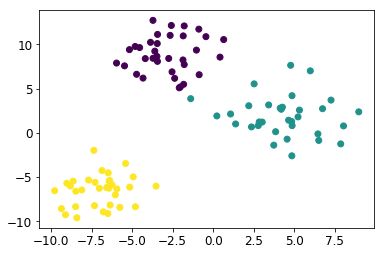

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_features=2, n_samples=100, cluster_std=[2.0, 2.3, 1.8], random_state=42)
plt.scatter(X[:,0], X[:,1], c=y)

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

In [7]:
def plot_predicted_label(ax, clf, xx, yy, X, t):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    
def plot_prob_density(ax, model, xx, yy, X, t):
    Z = model.calc_prob_density(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    ax.contour(xx, yy, Z)
    
def plot_result(model, xx, yy, X, t):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(121)
    plot_predicted_label(ax, model, xx, yy, X, t)
    ax = fig.add_subplot(122)
    plot_prob_density(ax, model, xx, yy, X, t)

## 4.2 Simple example

First, let us see the results for simply appying the model to the above data.

n_iter : 10
convergend : True
lower bound : -389.1578289309176
Change in the variational lower bound : -3.9195783756440505e-05


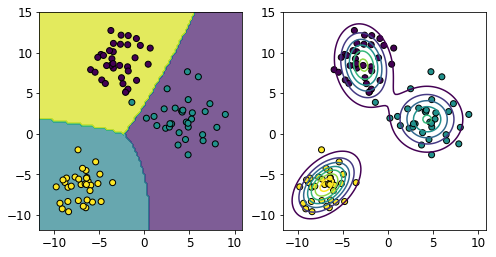

In [8]:
bgmm = BayesianGaussianMixtureModel(K=3, D=2, alpha0=1.0, beta0=1.0, nu0=2.0, m0=np.zeros(2), W0=np.eye(2))
bgmm.fit(X, max_iter=1000, tol=1e-4, random_state=42, disp_message=True)
plot_result(bgmm, xx, yy, X, y)
plt.show()

It seems that the model is properly fit to the data. 
However, due to the random initialization, different results may be obtained, whose example is given below.

n_iter : 8
convergend : True
lower bound : -397.75619724106684
Change in the variational lower bound : 1.2367827594061964e-05


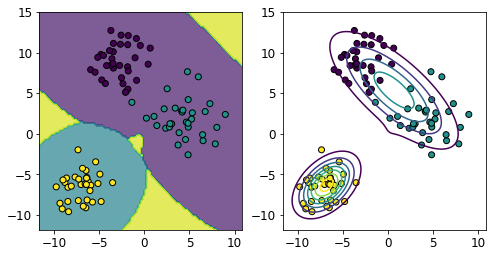

In [9]:
bgmm = BayesianGaussianMixtureModel(K=3, D=2, alpha0=1.0, beta0=1.0, nu0=2.0, m0=np.zeros(2), W0=np.eye(2))
bgmm.fit(X, max_iter=1000, tol=1e-4, random_state=0, disp_message=True)
plot_result(bgmm, xx, yy, X, y)
plt.show()

Intuitively speaking, the former result is more appropriate. This intuition is also supported from the fact that the former result has larger value of variational lower bound.

Also note that we took a somewhat arbitrary initialization, and better result may be obtained by using different initialization scheme.

## 4.2 Hyperparameter tuning

We can perform hyperparameter search using the variational lower bound as our criterion.

In [10]:
best_estimator = None
best_lower_bound = -np.float("inf")
m0 = np.zeros(2)

for alpha0 in [0.1, 1.0, 10.0, 100.0]:
    for beta0 in [0.01, 0.1, 1.0]:
        for nu0 in [1.1, 2.0, 11.0]:
            for W0 in [0.01*np.eye(2), 0.1*np.eye(2), np.eye(2), 10.0*np.eye(2)]:
                for random_state in np.arange(0,10,1):
                    bgmm = BayesianGaussianMixtureModel(K=3, D=2, alpha0=alpha0, beta0=beta0, nu0=nu0, m0=m0, W0=W0)
                    bgmm.fit(X, max_iter=1000, tol=1e-4, random_state=random_state, disp_message=False)
                    if bgmm.lower_bound > best_lower_bound:
                        best_estimator = bgmm
                        best_lower_bound = bgmm.lower_bound

C:\Users\sokohaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\sokohaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in multiply


lower_bound : -367.9533872980828


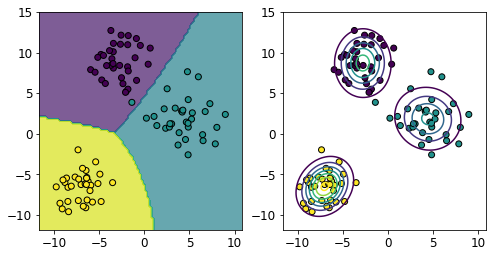

In [11]:
plot_result(best_estimator, xx, yy, X, y)
print(f"lower_bound : {best_lower_bound}")

In [12]:
print(f"alpha0 : {best_estimator.alpha0}")
print(f"beta0 : {best_estimator.beta0}")
print(f"nu0 : {best_estimator.nu0}")
print(f"m0 : {best_estimator.m0}")
print(f"W0 : {best_estimator.W0}")

alpha0 : 100.0
beta0 : 0.1
nu0 : 2.0
m0 : [0. 0.]
W0 : [[0.1 0. ]
 [0.  0.1]]


## 4.3 Results for larger $K$

Finally, let us see what happens if we choose a large value of $K$. 

Concretely, here we choose $K=10$. 
To cope with the initial conditoin dependence, for each value of `alpha0`, we try 10 random seeds, and select the best estimator.

Let us first try out a large value of $\alpha_0$, which, from the property of Dirichlet distribution, means that the model distribute the weight on many more components.

lower bound : -452.0379619828742


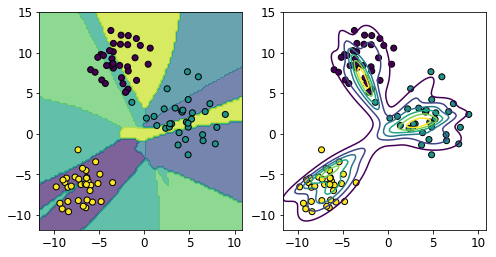

In [13]:
alpha0 = 10.0

best_estimator = None
best_lower_bound = -np.float("inf")

for random_state in np.arange(0,10,1):
    bgmm = BayesianGaussianMixtureModel(K=10, D=2, alpha0=alpha0, beta0=1.0, nu0=2.0, m0=np.zeros(2), W0=np.eye(2))
    bgmm.fit(X, max_iter=1000, tol=1e-4, random_state=random_state, disp_message=False)
    if bgmm.lower_bound > best_lower_bound:
        best_estimator = bgmm
        best_lower_bound = bgmm.lower_bound
        
plot_result(best_estimator, xx, yy, X, y)
print(f"lower bound : {best_lower_bound}")

As was anticipated, the model does not work well with the data, which can also be seen from the smaller value of variational lower bound. Next, let us try out a smaller value of $\alpha_0$, which is supposed to result in smaller numbers of components with non-negligible weight.

lower bound : -396.83871150380935


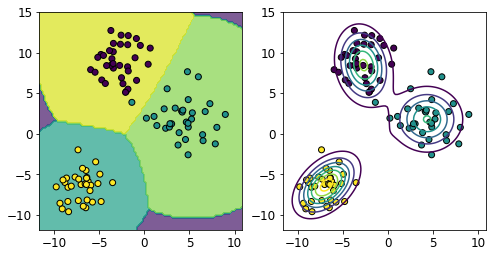

In [14]:
alpha0 = 0.1

best_estimator = None
best_lower_bound = -np.float("inf")

for random_state in np.arange(0,10,1):
    bgmm = BayesianGaussianMixtureModel(K=10, D=2, alpha0=alpha0, beta0=1.0, nu0=2.0, m0=np.zeros(2), W0=np.eye(2))
    bgmm.fit(X, max_iter=1000, tol=1e-4, random_state=random_state, disp_message=False)
    if bgmm.lower_bound > best_lower_bound:
        best_estimator = bgmm
        best_lower_bound = bgmm.lower_bound
        
plot_result(best_estimator, xx, yy, X, y)
print(f"lower bound : {best_lower_bound}")

Looks great! It is also much better in terms of the value of variational lower bound. 

Thus, we can see that, unlike the maximum likelihood estimation in Chapter 9, the Bayesian Gaussian mixture model can perform well even when we do not know the proper value of $K$, provided that we set large enough $K$ and $\alpha_0 < 1$.